## Small Dataset Full-Image Species Exploration 

In this notebook, we explore a portion of Haiti Tree Project (THTP) captures verified by Cam.

### Dependencies

In [1]:
import torch
import numpy as np
import pandas as pd
import os
import sklearn
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import urllib
from PIL import Image

from sklearn.manifold import TSNE

### Data Retrieval
 
 
For now, download each image/label pair Cam has specified ([Github link](https://github.com/Greenstand/Tree_Species/tree/master/training)).

In [2]:
datadir = "/home/ec2-user/SageMaker/treetracker-machine-learning/sample_datasets/Haiti/cam_training.psv"
baseurl = "https://treetracker-production-images.s3.eu-central-1.amazonaws.com/"
assert os.path.exists(datadir)
data = pd.read_csv(datadir, sep="|", header=None)
data.columns = ["class", "imname"]
data["url"] = baseurl + data["imname"]
data.head(5)

,class,imname,url
0,ACACAURI,2020.11.29.12.18.36_18.285143729299307_-73.564...,https://treetracker-production-images.s3.eu-ce...
1,ACACAURI,2020.11.29.12.18.59_18.285102993249893_-73.564...,https://treetracker-production-images.s3.eu-ce...
2,ACACAURI,2020.11.29.12.47.34_18.290133895352483_-73.557...,https://treetracker-production-images.s3.eu-ce...
3,ACACAURI,2020.11.29.12.50.51_18.29083981923759_-73.5582...,https://treetracker-production-images.s3.eu-ce...
4,ACACAURI,2020.11.29.13.29.55_18.29298411961645_-73.5581...,https://treetracker-production-images.s3.eu-ce...


In [3]:
savepath = "/home/ec2-user/SageMaker/treetracker-machine-learning/sample_datasets/Haiti/"
for species in data["class"].unique():
    os.makedirs(os.path.join(savepath, species))
image_saver = lambda df: urllib.request.urlretrieve(df["url"], os.path.join(savepath, df["class"], df["imname"]))
data.apply(image_saver, axis=1)


FileExistsError: [Errno 17] File exists: '/home/ec2-user/SageMaker/treetracker-machine-learning/sample_datasets/Haiti/ACACAURI'

388  total samples
Class breakdown
          imname  url
class                
ACACAURI     111  111
ANACOCCI      53   53
CATALONG      75   75
MANGINDI     149  149


Text(0.5, 1.0, 'Count per class')

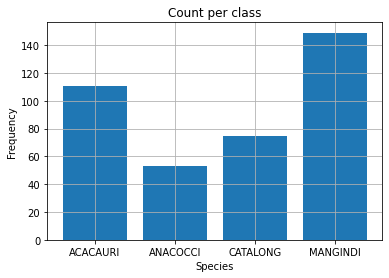

In [4]:
print (data.shape[0], " total samples")
print ("Class breakdown")
count_by_class = data.groupby("class").aggregate("count")
print (count_by_class)
plt.bar(count_by_class.index, count_by_class["imname"])
plt.grid()
plt.xlabel("Species")
plt.ylabel("Frequency")
plt.title("Count per class")

In [5]:
arrs = []
labels = []
for species in data["class"].unique():
    for img in os.listdir(os.path.join(savepath, species)):
        if os.path.splitext(os.path.join(savepath, species, img))[1].lower() in [".jpg", ".png"]:
            arrs.append(Image.open(os.path.join(savepath, species, img)).resize((224, 224)))
            labels.append(species)
            


In [6]:
X = np.vstack([np.asarray(img).flatten() for img in arrs])
X_embedded = TSNE(n_components=2, perplexity=30.0, learning_rate=25.0, n_iter=10000).fit_transform(X)

In [7]:
tsne_result = pd.DataFrame(X_embedded)
tsne_result["class"] = labels
tsne_result.columns = ["x0", "x1", "class"]
colors = np.linspace(0, 1, len(data["class"].unique()))
colordict = dict(zip(data["class"].unique(), colors))  
tsne_result["Color"] = tsne_result["class"].apply(lambda x: colordict[x])

In [8]:
print (tsne_result.head(5))

         x0        x1     class  Color
0  2.321052 -1.463953  ACACAURI    0.0
1 -1.892610  1.782233  ACACAURI    0.0
2 -2.444886  4.262923  ACACAURI    0.0
3  4.852048  0.186473  ACACAURI    0.0
4  2.103767  1.623747  ACACAURI    0.0


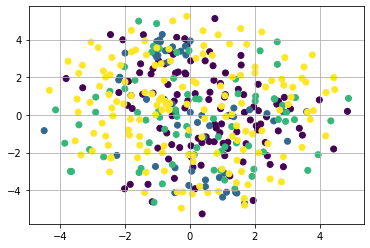

In [9]:
plt.grid()
plt.scatter(tsne_result["x0"], tsne_result["x1"], c=tsne_result["Color"])


In [ ]:
import torchvision.models as models
from torchvision import datasets, transforms as T

transform = T.Compose([T.Resize(512), T.CenterCrop(299), T.ToTensor()])

inception = models.inception_v3(pretrained=True)
inception.eval()


In [ ]:
preds = [inception(transform(img)[None, ...]) for img in arrs]